In [1]:
from collections import Counter

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import ucimlrepo

import dp_xgboost as xgb
import sklearn


/home/takeshi/git/dp-xgboost/python-package/dp_xgboost/compat.py:32: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Before running this notebook

1. Run the non-DP notebook (`GBDT_Adult_Demo.ipynb`)
2. Get the hyperparameters from each model that was saved
3. Retrain using the hyperparameters that we got

In [2]:
# Adult dataset: https://archive.ics.uci.edu/dataset/2/adult

adult = ucimlrepo.fetch_ucirepo(id=2)
# adult_df = pd.DataFrame(adult)
Counter(adult.data.targets['income'])


Counter({'<=50K': 24720, '>50K': 7841, '<=50K.': 12435, '>50K.': 3846})

In [3]:
adult.variables


,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,N/A,None,no
1,workclass,Feature,Categorical,Income,"Private, Self-emp-not-inc, Self-emp-inc, Feder...",None,yes
2,fnlwgt,Feature,Integer,None,None,None,no
3,education,Feature,Categorical,Education Level,"Bachelors, Some-college, 11th, HS-grad, Prof-...",None,no
4,education-num,Feature,Integer,Education Level,None,None,no
5,marital-status,Feature,Categorical,Other,"Married-civ-spouse, Divorced, Never-married, S...",None,no
6,occupation,Feature,Categorical,Other,"Tech-support, Craft-repair, Other-service, Sal...",None,yes
7,relationship,Feature,Categorical,Other,"Wife, Own-child, Husband, Not-in-family, Other...",None,no
8,race,Feature,Categorical,Race,"White, Asian-Pac-Islander, Amer-Indian-Eskimo,...",None,no
9,sex,Feature,Binary,Sex,"Female, Male.",None,no


In [4]:
adult.data.targets.describe()


,income
count,48842
unique,4
top,<=50K
freq,24720


In [5]:
adult.data.features.describe()


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


Get the training and validation data

In [6]:
adult.variables


,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,N/A,None,no
1,workclass,Feature,Categorical,Income,"Private, Self-emp-not-inc, Self-emp-inc, Feder...",None,yes
2,fnlwgt,Feature,Integer,None,None,None,no
3,education,Feature,Categorical,Education Level,"Bachelors, Some-college, 11th, HS-grad, Prof-...",None,no
4,education-num,Feature,Integer,Education Level,None,None,no
5,marital-status,Feature,Categorical,Other,"Married-civ-spouse, Divorced, Never-married, S...",None,no
6,occupation,Feature,Categorical,Other,"Tech-support, Craft-repair, Other-service, Sal...",None,yes
7,relationship,Feature,Categorical,Other,"Wife, Own-child, Husband, Not-in-family, Other...",None,no
8,race,Feature,Categorical,Race,"White, Asian-Pac-Islander, Amer-Indian-Eskimo,...",None,no
9,sex,Feature,Binary,Sex,"Female, Male.",None,no


In [7]:
categorical = [col for col in adult.data.features.columns if adult.data.features[col].dtype == 'object']
numerical = [col for col in adult.data.features.columns if adult.data.features[col].dtype != 'object']

features = adult.data.features.copy()
targets = adult.data.targets.copy()

# Replace any nan categories with '?'
features[categorical] = features[categorical].fillna('?')
features[categorical] = features[categorical].astype('category')

# Create mapping for all features from category to a numerical value
categories = {
    cat: sorted(features[cat].unique()) for cat in categorical
}

# Add '?' to every catgory as 0 index
categories = {cat: lst if lst[0] == '?' else ['?'] + lst for cat, lst in categories.items()}

features_numeric = features.copy()

# Replace the categories with their index positions
for col in categorical:
    features_numeric[col] = features[col].apply(lambda x: categories[col].index(x)).astype(int)

validation_mask = targets['income'].str.endswith('.')
low_mask = targets['income'].str.startswith('<')

targets_numeric = targets.copy()

# Replace the targets with binary classes
targets_numeric['income'][low_mask] = 0
targets_numeric['income'][~low_mask] = 1
targets_numeric['income'] = targets_numeric['income'].astype(bool)

In [8]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       48842 non-null  category
 2   fnlwgt          48842 non-null  int64   
 3   education       48842 non-null  category
 4   education-num   48842 non-null  int64   
 5   marital-status  48842 non-null  category
 6   occupation      48842 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  int64   
 11  capital-loss    48842 non-null  int64   
 12  hours-per-week  48842 non-null  int64   
 13  native-country  48842 non-null  category
dtypes: category(8), int64(6)
memory usage: 2.6 MB


# Visualize the data

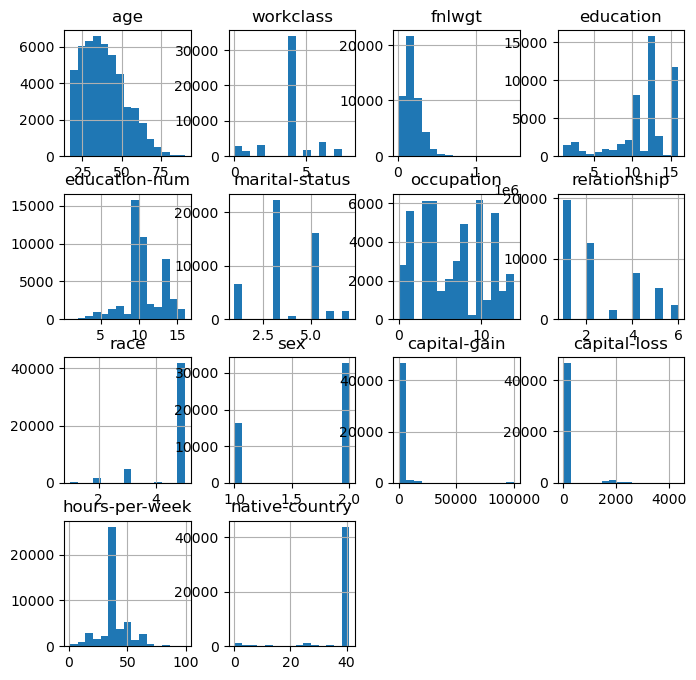

In [9]:
features_numeric.hist(bins=15, figsize=(8, 8));


array([[<Axes: title={'center': 'income'}>]], dtype=object)

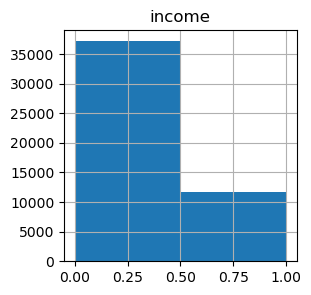

In [10]:
targets_numeric.astype(int).hist(bins=2, figsize=(3, 3))

# Make a DP GBDT model


In [12]:
# Old versions of XGBoost don't support arbitrary categories
# Converting to numeric values is also not an option, as there will be relative comparison, which is not applicable
# Instead we can hack it by converting to one-hot

features_copy = features.copy()

onehot_categorical = []
for cat in categorical:
    s = features[cat].unique()
    onehot_df = pd.get_dummies(s, prefix=f'{cat}')
    onehot_categorical.extend(list(onehot_df.columns))
    onehot_df[cat] = s
    features_copy = features_copy.merge(onehot_df, on=[cat], how='left')

all_columns = numerical + onehot_categorical

In [35]:
# Use the same parameters as in the original notebook
# Add DP parameters :)

dp_per_tree = 0.25
base_score = 0.5
subsample=0.2
# Get the min/max for dp training
feature_min = features_copy[all_columns][~validation_mask].min()
feature_max = features_copy[all_columns][~validation_mask].min()

params = {
    "model_params": {
        "n_estimators": 100,
        "tree_method": "hist",
        # 'tree_method':'approxDP', # this is Sarus XGBoost tree updater 
        # 'dp_epsilon_per_tree': dp_per_tree,
        "max_depth": 4,
        # "enable_categorical": True,
        # 'device': 'cuda',
        "eval_metric": [
            "logloss",
            "error",
            "auc",
            "aucpr",
            "map"
        ],
        'nthread': 32,
    },
    "train_params": {
        'verbose': False,
    }
}


paramsDP = {
    'objective': 'reg:squarederror',
    'tree_method':'approxDP', # this is Sarus XGBoost tree updater 
    'dp_epsilon_per_tree': dp_per_tree,
    'max_depth': 6,
    #'verbosity' : 3,
    'learning_rate' : 0.2,
    'lambda' : 0.1,
    'base_score' : base_score,
    'subsample' : subsample,
    'min_child_weight' : 1,
    'nthread' : 4,
    "eval_metric": [
        "logloss",
        "error",
        "auc",
        "aucpr",
        "map"
    ],
}

dtrain = xgb.DMatrix(
    data=features_copy[all_columns][~validation_mask],
    label=targets_numeric[~validation_mask],
    feature_min=features_copy[~validation_mask].min(),
    feature_max=features_copy[~validation_mask].max(),
)

dtest = xgb.DMatrix(
    data=features_copy[all_columns][validation_mask],
    label=targets_numeric[validation_mask],
    feature_min=features_copy[~validation_mask].min(),
    feature_max=features_copy[~validation_mask].max(),
)

train_history = {}
watchlist = [(dtest, "eval"), (dtrain, "train")]

best_booster = xgb.train(paramsDP, dtrain, num_boost_round=100, evals=watchlist, evals_result=train_history, verbose_eval=False)
clf = xgb.XGBClassifier(booster=best_booster, objective='reg:squarederror')

train_history['train'].keys()

/tmp/ipykernel_511953/3210542227.py:59: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  feature_min=features_copy[~validation_mask].min(),
/tmp/ipykernel_511953/3210542227.py:60: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  feature_max=features_copy[~validation_mask].max(),
/home/takeshi/git/dp-xgboost/python-package/dp_xgboost/data.py:209: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index

odict_keys(['logloss', 'error', 'auc', 'aucpr', 'map'])

In [36]:
clf

XGBClassifier(base_score=None,
              booster=<dp_xgboost.core.Booster object at 0x7fa0f78334f0>,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='reg:squarederror', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

Text(0.5, 1.0, 'Training Performance')

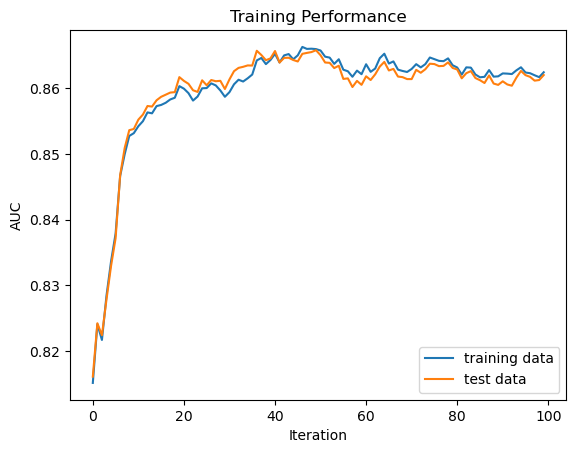

In [25]:
plt.plot(np.arange(params['model_params']['n_estimators']), train_history["train"]["auc"], label="training data")
plt.plot(np.arange(params['model_params']['n_estimators']), train_history["eval"]["auc"], label="test data")
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.title(f'Training Performance')


Text(0.5, 1.0, 'Training Performance')

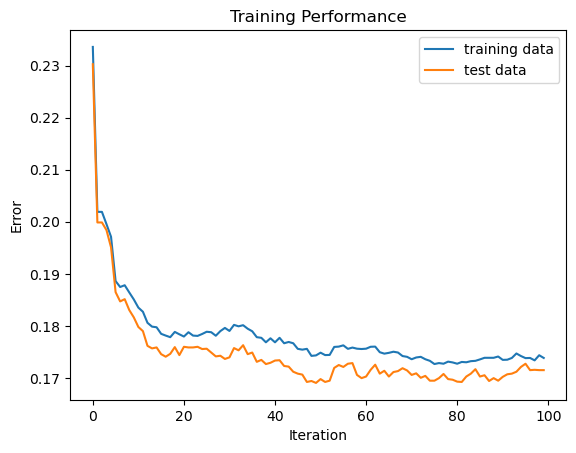

In [26]:
plt.plot(np.arange(params['model_params']['n_estimators']), train_history["train"]["error"], label="training data")
plt.plot(np.arange(params['model_params']['n_estimators']), train_history["eval"]["error"], label="test data")
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title(f'Training Performance')


In [27]:
y_pred_proba_train = clf.predict_proba(features[~validation_mask])
y_pred_proba_valid = clf.predict_proba(features[validation_mask])

fpr_train, tpr_train, _ = sklearn.metrics.roc_curve(targets_numeric[~validation_mask], y_pred_proba_train[:, 1])
fpr_valid, tpr_valid, _ = sklearn.metrics.roc_curve(targets_numeric[validation_mask], y_pred_proba_valid[:, 1])


auc_train = sklearn.metrics.auc(fpr_train, tpr_train)
auc_valid = sklearn.metrics.auc(fpr_valid, tpr_valid)

plt.plot(fpr_train, tpr_train, label="Training data")
plt.plot(fpr_valid, tpr_valid, label="Validation data")

plt.title(f"ROC curve, AUC=(test: {auc_valid:.4f}, train: {auc_train:.4f})")


NotFittedError: need to call fit or load_model beforehand

# GBDT with all other datasets

In [ ]:
import os
from pathlib import Path

from create_external_datasets import load_train_validation_test

DATASET_PATH = Path(os.path.abspath('third-party/tab-llm/datasets'))
dataset_names = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(DATASET_PATH / d)]
dataset_names

In [ ]:
def load_dataset(name):
    data = load_train_validation_test(name, DATASET_PATH / name)
    return data

def prepare_dataset(data, target_col_name='label'):
    r'''
    1. Changes the "object" types to "category"
    2. Splits all data into X, y pairs. y is the 'label' in the DataFrame
    3. ...
    4. Returns a copy of the data dict as well as two lists:
        - List of columns that are categorical
        - List of columns that are numerical
    '''
    result = {}
    categorical = []
    numerical = []
    for key, df in data.items():       
        categorical = [col for col in df.columns if df[col].dtype == 'object']
        numerical = [col for col in df.columns if df[col].dtype != 'object']

        df = df.copy()
        df[categorical] = df[categorical].astype('category')
        result[key] = df.loc[:, df.columns != target_col_name], df.loc[:, df.columns == target_col_name]
    return result, categorical, numerical

def train_gbdt(train_data, is_categorical=False, *, eval_data=None, init_kwargs=None, fit_kwargs=None, gridcv_params=None):
    init_kwargs = init_kwargs or {}
    fit_kwargs = fit_kwargs or {}

    # Data
    if isinstance(train_data, pd.DataFrame):
        train_X = train_data.loc[:, train_data.columns != 'label']
        train_y = train_data.label
    else:
        train_X, train_y = train_data
    num_class = len(train_y['label'].unique())
    is_multiclass = num_class > 2

    # Default Args
    params = {
        "model_params": {
            'n_estimators': 500,
            'max_depth': 4,
            'tree_method': "hist" if is_categorical else 'approx',
            'enable_categorical': is_categorical,
            'objective': 'multi:softprob' if is_multiclass else 'binary:logistic',
            # 'device': 'cuda',  # xgb 2+ only
            'gpu_id': 0,  # xgb <2
            "eval_metric": [
                "mlogloss" if is_multiclass else 'logloss',
                "merror" if is_multiclass else 'error',
                "auc",
                "aucpr",
                # "map",
            ],
        },
        "fit_params": {
            'verbose': False,
            'eval_set': [(train_X, train_y)],
            # 'n_classes': num_class,
        }
    }

    # Updated args
    params['model_params'].update(init_kwargs)
    params['fit_params'].update(fit_kwargs)
    
    if eval_data is not None:
        if isinstance(eval_data, pd.DataFrame):
            eval_X = eval_data.loc[:, eval_data.columns != 'label']
            eval_y = eval_data.label
        else:
            eval_X, eval_y = eval_data

        params['fit_params']['eval_set'].append((eval_X, eval_y))

    # Model
    clf = xgb.XGBClassifier(**params['model_params'])

    # Train
    if gridcv_params is not None and len(gridcv_params) > 0:
        num_classes = len(train_data[1].label.unique())
        if num_classes > 2:
            scoring = sklearn.metrics.make_scorer(sklearn.metrics.roc_auc_score, average='weighted', multi_class='ovr', needs_proba=True)
        else:
            scoring = 'roc_auc'
        grid_search = sklearn.model_selection.GridSearchCV(
            estimator = clf,
            param_grid = gridcv_params,
            scoring = scoring,
            n_jobs = 32,
            cv = 5,
            verbose = 1
        )
        grid_search.fit(train_X, train_y, **params['fit_params'])
        clf = grid_search.best_estimator_
    else:
        clf.fit(train_X, train_y, **params['fit_params'])
    train_history = clf.evals_result()

    if is_multiclass:
        for key in train_history:
            train_history[key]['logloss'] = train_history[key]['mlogloss']
            train_history[key]['error'] = train_history[key]['merror']

    return clf, train_history
# categorical, numerical

In [ ]:
def plot_metrics(model, history, train_data, eval_data):
    from matplotlib.patches import ConnectionPatch
    
    fig, ax = plt.subplots(2, 2, sharex='col', figsize=(8, 4.5))
    gs = ax[0, 1].get_gridspec()        

    # Left side
    num_iters = model.best_iteration + model.early_stopping_rounds + 1 if hasattr(model, 'best_iteration') else model.n_estimators
    num_iters = min(num_iters, model.n_estimators)
    best_iteration = model.best_iteration if hasattr(model, 'best_iteration') else model.n_estimators
    best_auc = history["validation_1"]["auc"][best_iteration]
    
    ax[0, 0].plot(np.arange(num_iters), history["validation_0"]["auc"], label="training data")
    ax[0, 0].plot(np.arange(num_iters), history["validation_1"]["auc"], label="test data")
    ax[0, 0].set_ylabel('AUC')
    ax[0, 0].set_title('Training Performance')
    if hasattr(model, 'best_iteration'):
        ax[0, 0].scatter([best_iteration], [best_auc], alpha=0.3)

    ax[1, 0].plot(np.arange(num_iters), history["validation_0"]["error"], label="training data")
    ax[1, 0].plot(np.arange(num_iters), history["validation_1"]["error"], label="test data")
    ax[1, 0].set_ylabel('Error')
    ax[1, 0].set_xlabel('Boosting Iteration')

    # Right side -- Combined axis
    ax[0, 1].remove()
    ax[1, 1].remove()
    axright = fig.add_subplot(gs[:, 1])

    y_pred_proba_train = model.predict_proba(train_data[0])
    y_pred_proba_valid = model.predict_proba(eval_data[0])

    y_train = train_data[1].to_numpy()
    y_valid = eval_data[1].to_numpy()
    num_classes = len(train_data[1].label.unique())
    if num_classes > 2:
        # RoC is not defined for multi-class -- use micro averaged OvR
        y_train = np.eye(num_classes)[y_train].ravel()
        y_pred_proba_train = y_pred_proba_train.ravel()
        y_valid = np.eye(num_classes)[y_valid].ravel()
        y_pred_proba_valid = y_pred_proba_valid.ravel()
    else:
        y_pred_proba_train = y_pred_proba_train[:, 1]
        y_pred_proba_valid = y_pred_proba_valid[:, 1]

    fpr_train, tpr_train, _ = sklearn.metrics.roc_curve(y_train, y_pred_proba_train)
    fpr_valid, tpr_valid, _ = sklearn.metrics.roc_curve(y_valid, y_pred_proba_valid)
    
    auc_train = sklearn.metrics.auc(fpr_train, tpr_train)
    auc_valid = sklearn.metrics.auc(fpr_valid, tpr_valid)
    
    axright.plot(fpr_train, tpr_train, label=f'Training data ({auc_train:.2%})')
    axright.plot(fpr_valid, tpr_valid, label=f'Validation data ({auc_valid:.2%})')
    axright.plot([0.0, 1.0], [0.0, 1.0], '--k', alpha=0.3)
    axright.legend(title='AUC')
    axright.set_xlabel('FPR')
    axright.set_ylabel('TPR')
    axright.set_title('Final Model (RoC)')

    for end_pos in ((0, 0), (0, 1)):
        cp = ConnectionPatch((best_iteration, best_auc), end_pos,
                             "data", "axes fraction",
                             axesA=ax[0, 0], axesB=axright,
                             color=[0, 0, 0, 0.3], linestyle='-.',
                             in_layout=False
                            )
        axright.add_artist(cp)
    
    return fig, ax, axright

In [ ]:
# Comment out the parameters to skip the grid search
grid_search_parameters = {
    'max_depth': [12, 10, 8, 6, 4, 2],
    'alpha': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.],
    'lambda': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.],
    'eta': [0.01, 0.03, 0.1, 0.3],
}

# Add to the skip list the datasets that you would like to skip
skip_list = set([
    # 'creditg',
    # 'income',
    # 'diabetes',
    # 'calhousing',
    # 'blood',
    # 'heart',
    # 'car',
    # 'jungle',
    # 'bank'
])

In [ ]:
# Create plots
save_path = os.path.join('models/gbdt')
os.makedirs(save_path, exist_ok=True)
for name in dataset_names:
    if name in skip_list:
        continue
    print(f'===> DEBUG: {name}')
    data = load_dataset(name)
    data_Xy, categorical, numerical = prepare_dataset(data)
    model, history = train_gbdt(data_Xy['train'], eval_data=data_Xy['validation'],
                                is_categorical=bool(len(categorical)),
                                init_kwargs={'early_stopping_rounds': 10},
                                gridcv_params=grid_search_parameters,
                               )
    plot_metrics(model, history, data_Xy['train'], data_Xy['validation'])
    skip_list.add(name)
    
    plt.suptitle(f'Dataset: {name}')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'{name}_plot.png'))
    model.save_model(os.path.join(save_path, f'{name}_model.json'))

This will generate a markdown table with results.
Add this table to the markdown file for rendering

In [ ]:
# Get model params, and write it as markdown for git readme

params_to_show = [
    'best_ntree_limit',  # Best number of estimators
    'max_depth',
    'alpha',
    'lambda',
    'eta'
]
params_str =  ' | '.join(params_to_show)

metrics_to_show = [  # validation_0 is training history, validation_1 is validation history
    ('validation_0', 'error'),
    ('validation_1', 'error'),
    ('validation_0', 'auc'),
    ('validation_1', 'auc'),
]
metrics_str = r' | '.join([f"{m[1]} ({'T' if m[0].endswith('0') else 'V'})" for m in metrics_to_show])

rows = []
rows.append(f'| Dataset | {params_str} | {metrics_str.format(m="T")} | Training History |')
rows.append('|:' + '|:'.join(['---'] * (len(params_to_show) + len(metrics_to_show) + 2)) + ':|')
for name in dataset_names:
    # Get the model
    model_path = os.path.join(save_path, f'{name}_model.json')
    history_plot_path = os.path.join(save_path, f'{name}_plot.png')
    loaded_model = xgb.XGBClassifier(n_estimators=1)
    loaded_model.load_model(model_path)

    # Get the model parameters
    pars = [str(loaded_model.get_params().get(v, getattr(loaded_model, v, None))) for v in params_to_show]

    # Get the training history and the best iteration results
    loaded_history = loaded_model.evals_result()
    best_iteration = loaded_model.best_iteration
    mets = [f'{loaded_history[phase][metric][best_iteration]:.2f}' for (phase, metric) in metrics_to_show]

    # Show row
    rows.append(f'| {name} | {" | ".join(pars)} | {" | ".join(mets)} | ![{name}]({history_plot_path}) |')

table = '\n'.join(rows)

In [ ]:
from IPython.display import Markdown, display_markdown

Markdown(table)
# print(table)
# display_markdown(table, raw=True)